In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,3)

In [2]:
fig_size = plt.rcParams["figure.figsize"]

In [3]:
fig_size

[20.0, 3.0]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [5]:
train_df = pd.read_csv('./train_data.tsv',sep='\t')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20010 entries, 0 to 20009
Data columns (total 5 columns):
일자      20010 non-null int64
time    20010 non-null object
식사내용    20010 non-null object
매출일자    20010 non-null float64
수량      20010 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 781.7+ KB


In [6]:
time_dummy = pd.get_dummies(train_df['time'])

In [7]:
train_df = pd.concat([train_df, time_dummy],axis=1)

In [8]:
num_values = 7
degrees_week = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_week)
sin_week = np.sin(np.deg2rad(degrees_week))
print(sin_week)
cos_week = np.cos(np.deg2rad(degrees_week))
print(cos_week)

num_values = 12
degrees_month = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_month)
sin_month = np.sin(np.deg2rad(degrees_month))
print(sin_month)
cos_month = np.cos(np.deg2rad(degrees_month))
print(cos_month)

num_values = 31
degrees_day = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_day)
sin_day = np.sin(np.deg2rad(degrees_day))
print(sin_day)
cos_day = np.cos(np.deg2rad(degrees_day))
print(cos_day)

[   0.           51.42857143  102.85714286  154.28571429  205.71428571
  257.14285714  308.57142857]
[ 0.          0.78183148  0.97492791  0.43388374 -0.43388374 -0.97492791
 -0.78183148]
[ 1.          0.6234898  -0.22252093 -0.90096887 -0.90096887 -0.22252093
  0.6234898 ]
[   0.   30.   60.   90.  120.  150.  180.  210.  240.  270.  300.  330.]
[  0.00000000e+00   5.00000000e-01   8.66025404e-01   1.00000000e+00
   8.66025404e-01   5.00000000e-01   1.22464680e-16  -5.00000000e-01
  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01  -5.00000000e-01]
[  1.00000000e+00   8.66025404e-01   5.00000000e-01   6.12323400e-17
  -5.00000000e-01  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01
  -5.00000000e-01  -1.83697020e-16   5.00000000e-01   8.66025404e-01]
[   0.           11.61290323   23.22580645   34.83870968   46.4516129
   58.06451613   69.67741935   81.29032258   92.90322581  104.51612903
  116.12903226  127.74193548  139.35483871  150.96774194  162.58064516
  174.19354839  185.806

In [9]:
def make_coord(date,num_class):
    # 1 ~ 12, 1 ~ 7, 1 ~ 31
    degrees = np.linspace(0,360,num_values + 1)[:-1]
    sin = np.sin(np.deg2rad(degrees))
    cos = np.cos(np.deg2rad(degrees))
    return sin, cos


def date2coord(date, sin, cos):
    return cos[date-1], sin[date-1]


def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:])
    day = datetime(y, m, d)
    return day.weekday()

In [10]:
train_df['month'] = train_df['일자'].apply(lambda x:int(str(x)[4:6]))
train_df['day'] = train_df['일자'].apply(lambda x:int(str(x)[6:]))
train_df['week'] = train_df['일자'].apply(date2week)
train_df['week'] = train_df['week'] + 1 
train_df['year'] = train_df['일자'].apply(lambda x:int(str(x)[:4]))

In [11]:
train_df['day_coord'] = train_df['day'].apply(date2coord, args=(sin_day, cos_day,))
train_df['month_coord'] = train_df['month'].apply(date2coord, args=(sin_month, cos_month))
train_df['week_coord'] = train_df['week'].apply(date2coord, args=(sin_week, cos_week,))

In [12]:
x_list = []

In [13]:
X_arr = pd.get_dummies(train_df['year']).values
x_list.append(X_arr)

In [14]:
X_arr = np.array(train_df['day_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [15]:
X_arr = np.array(train_df['month_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [16]:
X_arr = np.array(train_df['week_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [17]:
X_arr = train_df['아침'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['점심'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['점심2'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['저녁'].values.reshape(-1,1)
x_list.append(X_arr)

In [18]:
X_arr.shape

(20010, 1)

In [19]:
from konlpy.tag import Twitter
twitter = Twitter()

In [20]:
doc_list = train_df['식사내용'].apply(lambda x: ' '.join(x[:-1].split(','))).tolist()

In [21]:
#doc_list = train_df['식사내용'].apply(lambda x: ' '.join(twitter.morphs(' '.join(x[:-1].split(','))))).tolist()

In [22]:
doc_list[0]

'과일샐러드 닭죽 돈육마늘장조림 떡만두국 부추김무침 쌀밥 딸기잼(중) 비엔나구이 스크램블에그(경양식) 야채샐러드 크림스프(경양식) 토스트&모닝빵'

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000,ngram_range=range(1,3))

In [24]:
X_food = vectorizer.fit_transform(doc_list)

print(X_food.shape)

(20010, 2000)


In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [26]:
svd = TruncatedSVD(n_components=1000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd,normalizer)

In [27]:
X_lsa = lsa.fit_transform(X_food)
exp_var = svd.explained_variance_ratio_.sum()
print(X_lsa.shape, exp_var)

In [29]:
X_coord = np.concatenate(x_list,axis=1)
y = train_df['수량'].values.reshape(-1,1)
print(X_coord.shape, y.shape)

(20010, 25) (20010, 1)


In [30]:
from scipy import sparse

In [31]:
X_food.shape

(20010, 2000)

In [32]:
X = np.concatenate([X_lsa, X_coord],axis=1)

In [33]:
#X = sparse.hstack((X_lsa,X_coord))

In [34]:
X.shape

(20010, 1025)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [36]:
model = LinearRegression(normalize=True)

In [37]:
cross_val_score(model,X=X,y=y,cv=5, verbose=True,scoring='mean_squared_error')

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

array([ -8.95444274e+29,  -2.56419309e+29,  -5.54810686e+28,
        -1.08946730e+28,  -2.12207418e+26])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.68479938932862949

In [110]:
print("RMSE: %.2f"% math.sqrt(np.mean(( model.predict(X_test) - y_test) ** 2)))

RMSE: 6.55


In [111]:
print("RMSE: %.2f"% math.sqrt(np.mean(( model.predict(X_train) - y_train) ** 2)))

RMSE: 6.43


In [112]:
pred = model.predict(X_test)

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


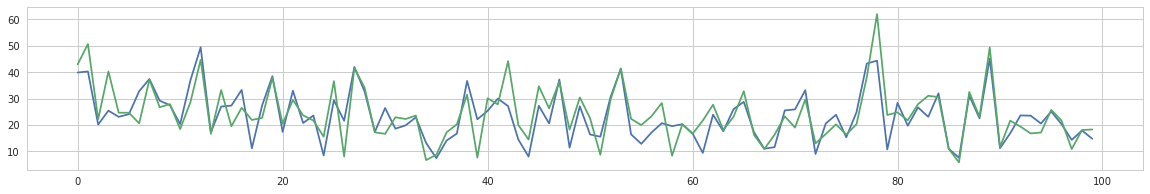

In [113]:
index = 1400
plt.plot(pred[index:index+100])
plt.plot(y_test[index:index+100])

### sklearn dnn

In [43]:
from sklearn.neural_network import MLPRegressor

In [44]:
mlpr = MLPRegressor(hidden_layer_sizes=(100, 5))

In [45]:
mlpr.fit(X_train,y_train.reshape(len(y_train),))

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [46]:
print("RMSE: %.2f"% math.sqrt(np.mean(( mlpr.predict(X_test) - y_test) ** 2)))

RMSE: 16.71


### keras dnn model

In [47]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input

Using TensorFlow backend.


In [51]:
# define base model
def baseline_model():
    visible = Input(shape=(1025,))
    hidden1 = Dense(10, activation='relu')(visible)
    hidden1 = Dense(10, activation='relu')(hidden1)
    hidden1 = Dense(10, activation='relu')(hidden1)
    output = Dense(1, activation='tanh')(hidden1)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()
    
    return model

In [52]:
dnn = baseline_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1025)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10260     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 10,491
Trainable params: 10,491
Non-trainable params: 0
_________________________________________________________________


In [53]:
dnn.fit(x=X_train,y=y_train,batch_size=100,epochs=3)

Epoch 1/3
16008/16008 [==============================] - 1s 36us/step - loss: 664.5794
Epoch 2/3
16008/16008 [==============================] - 0s 29us/step - loss: 647.9875
Epoch 3/3
16008/16008 [==============================] - 0s 28us/step - loss: 647.8469


In [54]:
print("RMSE: %.2f"% math.sqrt(np.mean(( dnn.predict(X_test) - y_test) ** 2)))

RMSE: 25.53


### randomforest

In [55]:
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model_rfr.fit(X_train,y_train)

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [56]:
print("RMSE: %.2f"% math.sqrt(np.mean((model_rfr.predict(X_test) - y_test) ** 2)))

RMSE: 15.88


### xgboost

In [57]:
import xgboost

In [58]:
xgb = xgboost.XGBRegressor(n_estimators=100, booster='gblinear', learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=3, n_job=4)

In [59]:
%%time
xgb.fit(X_train,y_train)

CPU times: user 7.48 s, sys: 54.4 ms, total: 7.53 s
Wall time: 7.53 s


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_job=4, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.75)

In [60]:
print("RMSE: %.2f"% math.sqrt(np.mean((xgb.predict(X_test) - y_test) ** 2)))

RMSE: 12.03


### svr

In [61]:
from sklearn.svm import LinearSVR

In [62]:
clf = LinearSVR(C=1.0,epsilon=0.2, max_iter=100000,tol=0.000001)
clf.fit(X_train, y_train)

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR(C=1.0, dual=True, epsilon=0.2, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100000,
     random_state=None, tol=1e-06, verbose=0)

In [63]:
print("RMSE: %.2f"% math.sqrt(np.mean((clf.predict(X_test) - y_test) ** 2)))

RMSE: 14.88
